# P-median model


Decision variables
- Whether or not to have a hospital at location $j$, $X_j$
- Whether or not to allocate customer $i$ to hospital at $j$, $Y_{ij}$

Constraints
- You can only allocate to hospitals that exist
$\forall i,j Y_{ij} \leq X_j$, alternatively $\forall j \sum_i^m Y_{ij} \leq m X_j$ 
- Each person needs to be allocated to one hospital $\forall i \sum_j^n Y_{ij} = 1$
- Need to locate exactly $p$ hospitals $\sum_j X_j = p$

Objective function
- Minimize the sum of $Y_{ij} cost(i,j)$, the sum of all the costs to reach hospital $j$ from location $i$

Note:
- The entire constraint matrix is only dependent on $p$, $n$, and $m$, the only part that actually depends on the actual lat/long locations is the objective function
- So I should write something that generates the entire constraint matrix given the constants

In [26]:
import numpy as np
from scipy.optimize import linprog

In [27]:
def p_median_constraint_matrix(num_hospitals, num_patients, num_locations):
    # n = num_locations
    # p = num_hospitals
    # m = num_patients
    # layout of decision vector
    # lentgh = n + n*m
    # first n entries -> binary, whether or not a hospital is located at location j
    # next n entries -> binary, which hospital is this patient allocated to, only one should be equal to one
    # ^ one of those sets for each patient, total = m
    vec_size = num_locations + num_locations * num_patients

    # number of constraints
    # leq constraints 
    # n constraints for the first set

    # equality constraints
    # m constraints for the second set
    # one constraint for the last set

    A_leq = np.empty((num_locations, vec_size))
    b_leq = np.empty(num_locations)

    A_eq = np.empty((num_patients + 1, vec_size))
    b_eq = np.empty(num_patients + 1)

    # first set of constraints -> all patients must be allocated to hospitals that exist
    # attempting to do the smaller constraint set to improve performance (yes i know premature optimization yada yada whatever it should be fine)
    constraint_leq_num = 0
    for j in range(num_locations):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes % num_locations == j] = 1
        row[j] = -num_patients
        A_leq[constraint_leq_num:] = row
        b_leq[constraint_leq_num] = 0
        constraint_leq_num += 1

    # second set of constraints -> everyone is allocated to one hospital
    constraint_eq_num = 0
    for i in range(num_patients):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes // num_locations == i + 1] = 1
        A_eq[constraint_eq_num:] = row
        b_eq[constraint_eq_num] = 1
        constraint_eq_num += 1

    # third constraint -> exactly p hospitals are allocated
    row = np.zeros(vec_size)
    indexes = np.array(range(vec_size))
    row[indexes < num_locations] = 1
    A_eq[-1:] = row
    b_eq[-1:] = num_hospitals

    bounds = np.array([(0, 1) for _ in range(vec_size)])
    integrality = np.ones(vec_size)
    return A_leq, b_leq, A_eq, b_eq, bounds, integrality

In [28]:
def p_median_objective_function(distances):
    _, num_locations = np.shape(distances)
    return np.append(np.zeros(num_locations), np.ndarray.flatten(distances))

In [29]:
def p_median_interpret_solution(solution, num_hospitals, num_patients, num_locations, output=True):
    solution_x = np.array([round(v) for v in solution.x])
    if solution.status != 0 and output:
        print(f"linprog failed: {solution.status}")
    mistakes = 0
    choices = np.array(range(num_locations))[solution_x[:num_locations] == 1]
    if output:
        print(f"Solution allocates hospitals at: {choices}")
    if len(choices) != num_hospitals:
        if output:
            print(f"!! Failed to allocate the right number of hospitals! | Allocated {len(choices)} out of {num_hospitals}")
        mistakes += 1

    vec_size = num_locations + num_locations * num_patients
    for i in range(num_patients):
        indexes = np.array(range(vec_size))
        patient_allocation = solution_x[indexes // num_locations == i + 1]
        choice = np.array(range(num_locations))[patient_allocation == 1]
        if output:
            print(f"Patient #{i} => {choice}")
        if len(choice) != 1:
            if output:
                print(f"!! Failed to properly allocate patient #{i}")
            mistakes += 1
            continue
        if not choice[0] in choices:
            if output:
                print(f"Allocated patient #{i} to a location that does not exist ({choice})")
            mistakes += 1
            continue
    if mistakes > 0:
        print("MISTAKES FOUND!!!")
        return mistakes
    return choices

In [30]:
A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=1, num_patients=2, num_locations=3)

# two patients, A prefers location 1, B prefers location 2 but is ok with location 1
# location 1 should get allocated
distances = np.array([[1, 5, 7], [3, 1, 7]])
c = p_median_objective_function(distances)

In [31]:
solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
solution.x
p_median_interpret_solution(solution, 1, 2, 3)

Solution allocates hospitals at: [0]
Patient #0 => [0]
Patient #1 => [0]


array([0])

In [32]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/mnt/h/Documents/fifth_year_shit/math441/project/utils.py'>

69


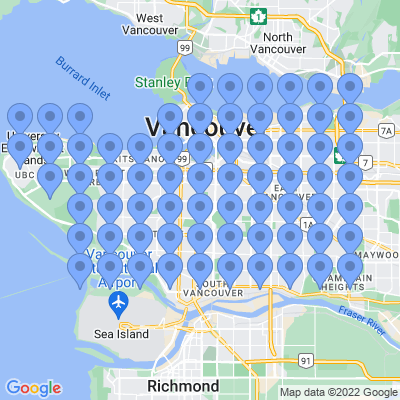

In [33]:
test_problem_points = utils.equidistant_points()
test_problem_points = list(filter(utils.is_on_land, test_problem_points))
print(len(test_problem_points))
display(utils.get_map(utils.vancouver_center, markers=[("blue", test_problem_points)], zoom=11))
distances = utils.straight_line_distance_matrix(test_problem_points, test_problem_points)

In [34]:
# build all the models we want to evaluate
all_models = {}

# models where we just consider our equidistant points as all sources and destinations
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(test_problem_points)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"all_points_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [0] | Cost (avg distance in km)= 5.118056283437807
Hospitals = 2 | Choices = [4 5] | Cost (avg distance in km)= 3.50125482123748
Hospitals = 3 | Choices = [ 6 40 42] | Cost (avg distance in km)= 2.930294478356253
Hospitals = 4 | Choices = [ 8 27 38 39] | Cost (avg distance in km)= 2.5124638949091778
Hospitals = 5 | Choices = [11 26 41 43 45] | Cost (avg distance in km)= 2.1623216229096
Hospitals = 6 | Choices = [11 30 34 43 44 45] | Cost (avg distance in km)= 1.9604212238705105
Hospitals = 7 | Choices = [ 4 27 30 35 37 44 45] | Cost (avg distance in km)= 1.7891217239100883
Hospitals = 8 | Choices = [18 19 30 34 35 44 45 47] | Cost (avg distance in km)= 1.6522958591236137
Hospitals = 9 | Choices = [ 1 18 27 30 34 44 45 55 62] | Cost (avg distance in km)= 1.5602074694981256


In [35]:
# models where we optimize for response to senior populations
senior_population_distances = utils.straight_line_distance_matrix(utils.senior_population_points, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    patients = utils.senior_population_points
    num_patients = len(patients)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(senior_population_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"senior_population_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [1] | Cost (avg distance in km)= 4.199964524714249
Hospitals = 2 | Choices = [11 43] | Cost (avg distance in km)= 3.1063582899361806
Hospitals = 3 | Choices = [11 30 43] | Cost (avg distance in km)= 2.436182147668265
Hospitals = 4 | Choices = [11 30 39 43] | Cost (avg distance in km)= 1.8919637688823463
Hospitals = 5 | Choices = [14 15 30 39 47] | Cost (avg distance in km)= 1.4897252414789717
Hospitals = 6 | Choices = [14 15 25 30 39 47] | Cost (avg distance in km)= 1.275050543757983
Hospitals = 7 | Choices = [12 14 25 30 37 39 47] | Cost (avg distance in km)= 1.1049378256800466
Hospitals = 8 | Choices = [11 12 18 25 30 37 39 47] | Cost (avg distance in km)= 0.9794734833259497
Hospitals = 9 | Choices = [ 4 11 12 25 30 36 37 39 47] | Cost (avg distance in km)= 0.8794766093220303


In [36]:
# models where we optimize for a population density based sample
import random
population_sample = random.choices(utils.all_points, weights=utils.all_points_weights, k=len(test_problem_points))
sample_distances = utils.straight_line_distance_matrix(population_sample, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(population_sample)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(sample_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"population_density_sample_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [1] | Cost (avg distance in km)= 3.653319304856238
Hospitals = 2 | Choices = [11 23] | Cost (avg distance in km)= 2.5574648840921697
Hospitals = 3 | Choices = [ 4 23 35] | Cost (avg distance in km)= 2.078324739908422
Hospitals = 4 | Choices = [ 4 17 23 33] | Cost (avg distance in km)= 1.7944030685374655
Hospitals = 5 | Choices = [ 4 17 19 27 33] | Cost (avg distance in km)= 1.6098097727550502
Hospitals = 6 | Choices = [ 3  4 27 33 37 42] | Cost (avg distance in km)= 1.4283314595027976
Hospitals = 7 | Choices = [ 3 16 18 27 33 40 42] | Cost (avg distance in km)= 1.3009291226296804
Hospitals = 8 | Choices = [ 3 16 18 27 33 35 40 42] | Cost (avg distance in km)= 1.2108018989376397
Hospitals = 9 | Choices = [ 3 16 18 27 33 35 40 42 52] | Cost (avg distance in km)= 1.1312351663692093


In [37]:
# evaluate each model by each method
model_results = {}
for name, choices in all_models.items():
    print(name, choices)
    hospitals = [test_problem_points[h] for h in choices]
    uniform_eval = utils.uniform_random_evaluate_solution(hospitals)
    population_eval = utils.population_sample_evaluate_solution(hospitals)
    senior_eval = utils.senior_population_sample_evaluate_solution(hospitals)
    model_results[name] = (uniform_eval, population_eval, senior_eval)

all_points_1 [0]
all_points_2 [4 5]
all_points_3 [ 6 40 42]
all_points_4 [ 8 27 38 39]
all_points_5 [11 26 41 43 45]
all_points_6 [11 30 34 43 44 45]
all_points_7 [ 4 27 30 35 37 44 45]
all_points_8 [18 19 30 34 35 44 45 47]
all_points_9 [ 1 18 27 30 34 44 45 55 62]
senior_population_1 [1]
senior_population_2 [11 43]
senior_population_3 [11 30 43]
senior_population_4 [11 30 39 43]
senior_population_5 [14 15 30 39 47]
senior_population_6 [14 15 25 30 39 47]
senior_population_7 [12 14 25 30 37 39 47]
senior_population_8 [11 12 18 25 30 37 39 47]
senior_population_9 [ 4 11 12 25 30 36 37 39 47]
population_density_sample_1 [1]
population_density_sample_2 [11 23]
population_density_sample_3 [ 4 23 35]
population_density_sample_4 [ 4 17 23 33]
population_density_sample_5 [ 4 17 19 27 33]
population_density_sample_6 [ 3  4 27 33 37 42]
population_density_sample_7 [ 3 16 18 27 33 40 42]
population_density_sample_8 [ 3 16 18 27 33 35 40 42]
population_density_sample_9 [ 3 16 18 27 33 35 40 42 5

In [38]:
for name, results in model_results.items():
    print(f"{name} => {[round(r[0],3) for r in results]}")

all_points_1 => [5.153, 4.389, 4.362]
all_points_2 => [3.555, 3.209, 3.327]
all_points_3 => [2.969, 2.959, 2.829]
all_points_4 => [2.533, 2.566, 2.622]
all_points_5 => [2.19, 2.159, 2.166]
all_points_6 => [2.056, 2.014, 1.876]
all_points_7 => [1.939, 1.773, 1.701]
all_points_8 => [1.784, 1.636, 1.611]
all_points_9 => [1.669, 1.609, 1.624]
senior_population_1 => [5.117, 3.978, 4.093]
senior_population_2 => [4.226, 2.992, 3.035]
senior_population_3 => [3.314, 2.805, 2.538]
senior_population_4 => [2.946, 2.436, 1.997]
senior_population_5 => [2.598, 2.097, 1.581]
senior_population_6 => [2.394, 1.93, 1.27]
senior_population_7 => [2.214, 1.851, 1.118]
senior_population_8 => [2.072, 1.681, 0.988]
senior_population_9 => [1.902, 1.541, 0.941]
population_density_sample_1 => [5.233, 4.049, 4.092]
population_density_sample_2 => [4.131, 2.812, 2.995]
population_density_sample_3 => [3.207, 2.39, 2.686]
population_density_sample_4 => [2.966, 2.143, 2.398]
population_density_sample_5 => [2.824, 1.888,

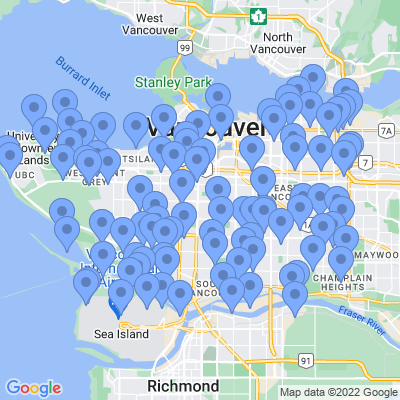

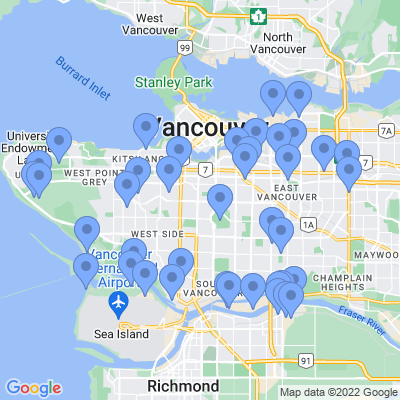

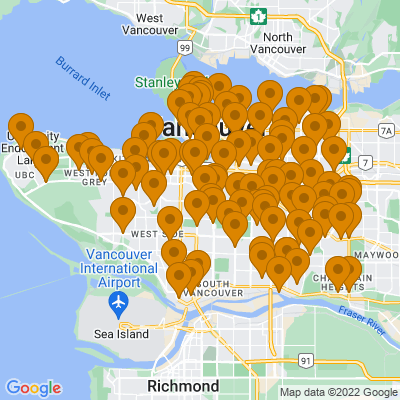

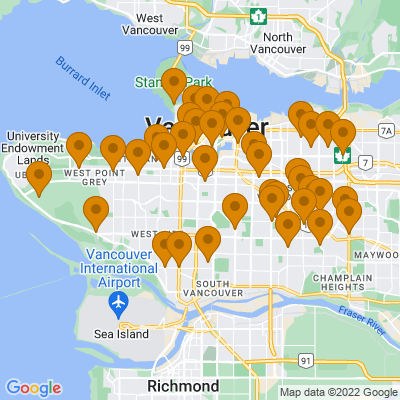

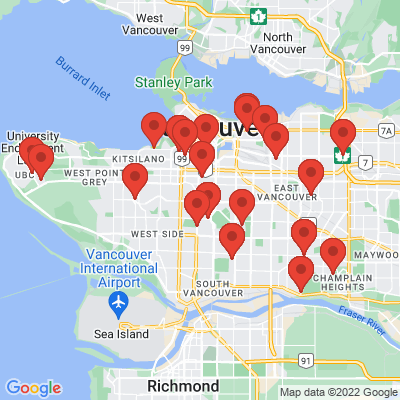

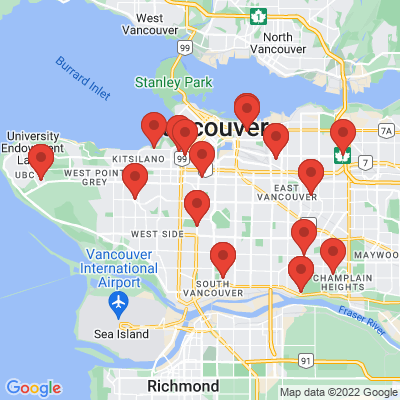

In [45]:
# uniform sample
display(utils.get_map(utils.vancouver_center, markers=[('blue', model_results["all_points_1"][0][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('blue', model_results["all_points_2"][0][1][:40])]))

# senior population sample
display(utils.get_map(utils.vancouver_center, markers=[('orange', model_results["all_points_1"][1][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('orange', model_results["all_points_2"][1][1][:40])]))

# population density sample
display(utils.get_map(utils.vancouver_center, markers=[('red', model_results["all_points_1"][2][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('red', model_results["all_points_2"][2][1][:40])]))